In [1]:
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer

# Load the unseen data
clv_unseen = pd.read_csv('new_obs_unseen_dummy3.csv')

# Split the unseen data into two halves (50% each), stratified by the 'Response'
clv_unseen_untreated, clv_unseen_treated = train_test_split(
    clv_unseen,
    stratify=clv_unseen['Response'],
    test_size=0.5,
    random_state=42
)

In [2]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import joblib
from lime.lime_tabular import LimeTabularExplainer

# Step 2: Load and Prepare the Data
# Assuming 'clv_unseen_treated' is a DataFrame with the treated unseen test data
# Drop unnecessary columns
clv_unseen_treated = clv_unseen_treated.drop(columns=['Customer', 'Effective To Date', 'Unnamed: 0'])

# Map 'Yes'/'No' to 1/0 in the Response column
clv_unseen_treated['Response'] = clv_unseen_treated['Response'].map({'Yes': 1, 'No': 0}).astype(float)

# Apply logarithmic transformation
clv_unseen_treated['CLV_log'] = np.log1p(clv_unseen_treated['Customer Lifetime Value'])
clv_unseen_treated['Income_Log'] = np.log1p(clv_unseen_treated['Income'])
clv_unseen_treated['TCA_Log'] = np.log1p(clv_unseen_treated['Total Claim Amount'])

# Drop the original columns after logging
clv_unseen_treated = clv_unseen_treated.drop(columns=['Customer Lifetime Value', 'Income', 'Total Claim Amount'])

# Split treated data into features and target variable
X_unseen_treated = clv_unseen_treated.drop(columns=['Response'])
y_unseen_treated = clv_unseen_treated['Response']

# Step 3: Load the Pre-trained Pipeline
pipe_tuned_pipeline = joblib.load('pipe_tuned_pipeline.pkl')

# Access the transformer step from the pipeline
transformer = pipe_tuned_pipeline.named_steps['transformer']  # Replace 'transformer' with the actual step name

# Step 4: Ensure the input to the transformer is a DataFrame
# Selecting a sample of the unseen treated data
X_sample = X_unseen_treated.head(1)

# Transform the sample to get a sense of the transformed feature set
X_sample_transformed = transformer.transform(X_sample)

# Attempt to get feature names from the transformer
try:
    feature_names_transformed = transformer.get_feature_names_out()
except AttributeError:
    # If the transformer does not have get_feature_names_out method, manually handle this
    feature_names_transformed = X_unseen_treated.columns

# Step 5: Initialize LIME Explainer
explainer = LimeTabularExplainer(
    X_sample_transformed,                     # Transformed data sample
    feature_names=feature_names_transformed,  # Transformed feature names
    class_names=['No', 'Yes'],                # Class names for binary classification
    mode='classification'                     # Because you are dealing with a classification problem
)

# Step 6: Select a Sample for Explanation
i = 0  # Index of the sample to explain
sample = X_unseen_treated.iloc[i:i+1]  # Keep sample as DataFrame

# Transform the sample using the transformer to ensure consistency
sample_transformed = transformer.transform(sample)

# Step 7: Generate Explanation with LIME
exp = explainer.explain_instance(
    sample_transformed[0],                   # Transformed instance to explain
    pipe_tuned_pipeline.predict_proba,       # Model's predict_proba method
    num_features=5                           # Number of features to include in explanation
)

# Step 8: Display the Explanation
exp.show_in_notebook()

ValueError: Specifying the columns using strings is only supported for dataframes.

In [2]:
def f2_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

f2_scorer = make_scorer(f2_score)

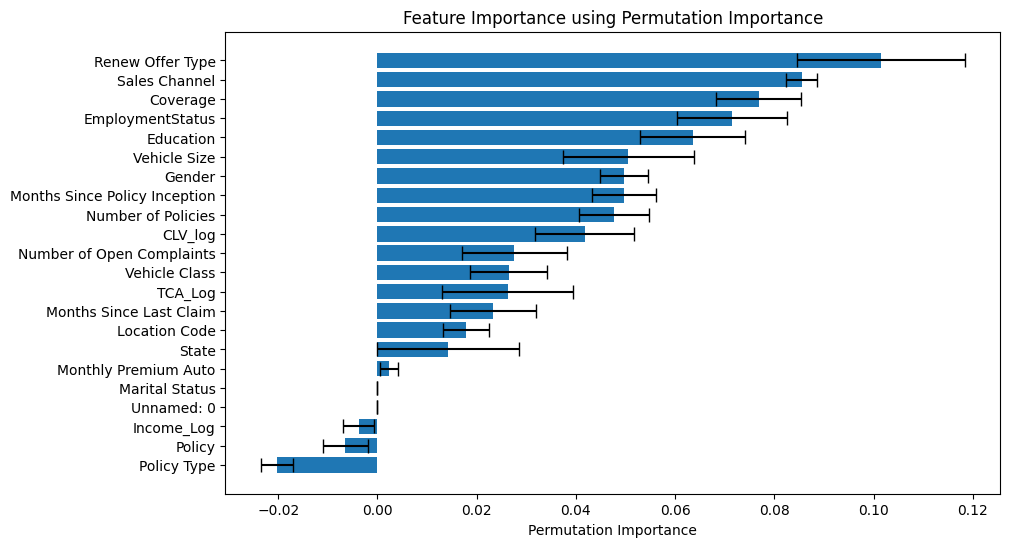

In [3]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np
import joblib

# Load the pipe_tuned pipeline
pipe_tuned_pipeline = joblib.load('pipe_tuned_pipeline.pkl')

# Load and preprocess the data
clv_unseen_treated = clv_unseen_treated.drop(columns=['Customer', 'Effective To Date'])
clv_unseen_treated['Response'] = clv_unseen_treated['Response'].map({'Yes': 1, 'No': 0}).astype(float)
clv_unseen_treated['CLV_log'] = np.log1p(clv_unseen_treated['Customer Lifetime Value'])
clv_unseen_treated['Income_Log'] = np.log1p(clv_unseen_treated['Income'])
clv_unseen_treated['TCA_Log'] = np.log1p(clv_unseen_treated['Total Claim Amount'])
clv_unseen_treated = clv_unseen_treated.drop(columns=['Customer Lifetime Value', 'Income', 'Total Claim Amount'])

X_unseen_treated = clv_unseen_treated.drop(columns=['Response'])
y_unseen_treated = clv_unseen_treated['Response']

# Compute permutation importance
results = permutation_importance(pipe_tuned_pipeline, X_unseen_treated, y_unseen_treated, scoring=f2_scorer)

# Get the importance values and standard deviations
importance = results.importances_mean
std = results.importances_std

# Sort features by importance
sorted_idx = np.argsort(importance)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(X_unseen_treated.columns[sorted_idx], importance[sorted_idx], xerr=std[sorted_idx], capsize=5)
plt.xlabel('Permutation Importance')
plt.title('Feature Importance using Permutation Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

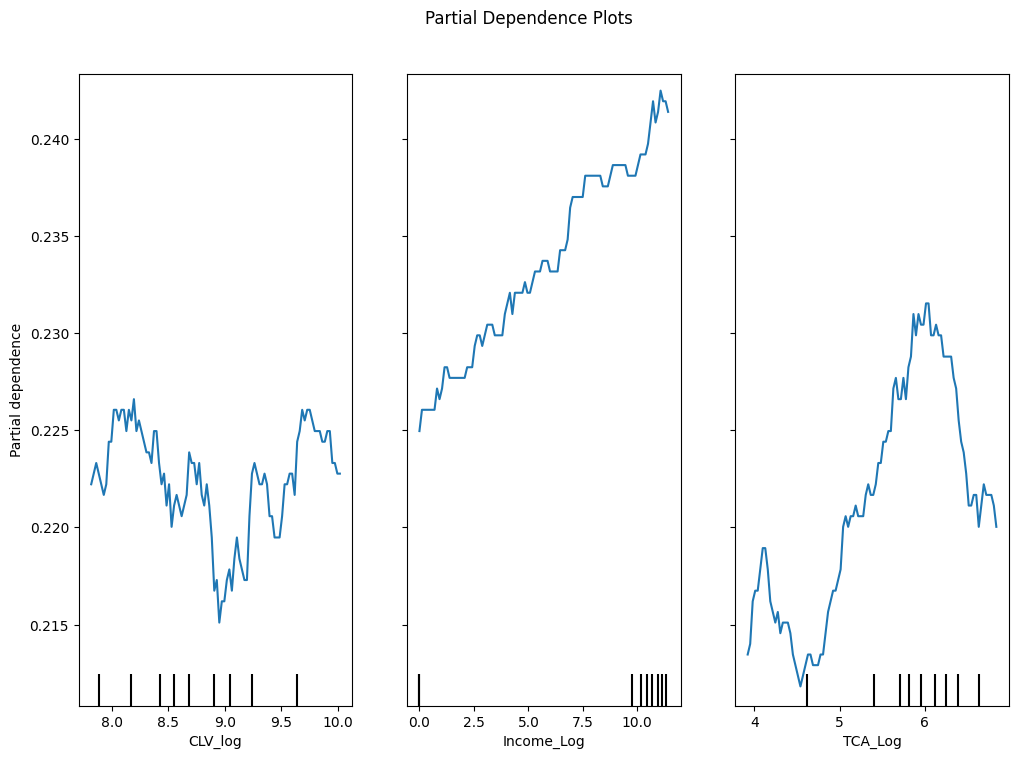

In [5]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Load the pipe_tuned pipeline
pipe_tuned_pipeline = joblib.load('pipe_tuned_pipeline.pkl')

# Load and preprocess the data
clv_unseen_treated = pd.read_csv('new_obs_unseen_dummy3.csv')
clv_unseen_treated = clv_unseen_treated.drop(columns=['Customer', 'Effective To Date'])
clv_unseen_treated['Response'] = clv_unseen_treated['Response'].map({'Yes': 1, 'No': 0}).astype(float)
clv_unseen_treated['CLV_log'] = np.log1p(clv_unseen_treated['Customer Lifetime Value'])
clv_unseen_treated['Income_Log'] = np.log1p(clv_unseen_treated['Income'])
clv_unseen_treated['TCA_Log'] = np.log1p(clv_unseen_treated['Total Claim Amount'])
clv_unseen_treated = clv_unseen_treated.drop(columns=['Customer Lifetime Value', 'Income', 'Total Claim Amount'])

X_unseen_treated = clv_unseen_treated.drop(columns=['Response'])
y_unseen_treated = clv_unseen_treated['Response']

# Create Partial Dependence Plots
features = ['CLV_log', 'Income_Log', 'TCA_Log']  # List your features here

# Generate the plots
fig, ax = plt.subplots(figsize=(12, 8))
display = PartialDependenceDisplay.from_estimator(pipe_tuned_pipeline, X_unseen_treated, features, ax=ax)
plt.suptitle('Partial Dependence Plots')
plt.subplots_adjust(top=0.9)  # Adjust the title position
plt.show()